This Notebook is a Sequence-to-Sequence Model for Text Summarization task using Attention Model

In [0]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, Concatenate, Permute, Dot, Multiply
from keras.layers import RepeatVector, Lambda, TimeDistributed, merge, Reshape
from keras.layers import multiply as mul
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
from utils import *
import pandas as pd
#from nltk.corpus import stopwords
from pickle import dump, load
import re
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from attention import AttentionDecoder

In [0]:
reviews = pd.read_csv("dataset/Reviews.csv")

In [0]:
print(reviews.shape)
print(reviews.head())
print(reviews.isnull().sum())

In [0]:
reviews = reviews.dropna()
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator', 'Score','Time'], 1)
reviews = reviews.reset_index(drop=True) 
print(reviews.head())
for i in range(5):
    print("Review #",i+1)
    print(reviews.Summary[i])
    print(reviews.Text[i])
    print()
    

In [0]:
contractions = {"ain't": "am not",
                "aren't": "are not",
                "can't": "cannot",
                "can't've": "cannot have",
                "'cause": "because",
                "could've": "could have",
                "couldn't": "could not",
                "couldn't've": "could not have",
                "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not",
                "hadn't": "had not",
                "hadn't've": "had not have",
                "hasn't": "has not",
                "haven't": "have not",
                "he'd": "he would",
                "he'd've": "he would have"}

In [0]:
def clean_text(text, remove_stopwords = True):
    # Convert words to lower case
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
        text = re.sub(r'\<a href', ' ', text)
        text = re.sub(r'</code>&<code>', '', text)
        text = re.sub(r'[_"\-;%()|+&=*%!?:#$@\[\]/]', ' ', text)
        text = re.sub(r'</code><br /><code>', ' ', text)
        text = re.sub(r'\'', ' ', text)
        if remove_stopwords:
            text = text.split()
            stops = set(stopwords.words("english"))
            text = [w for w in text if not w in stops]
            text = " ".join(text)
        return text

In [0]:
clean_summaries = []
for summary in reviews.Summary:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print("Summaries are complete.")
clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(text , remove_stopwords = False))
print("Texts are complete.")

In [0]:
stories = list()
for i, text in enumerate(clean_texts):
    stories.append({'story': text, 'highlights': clean_summaries[i]})
# save to file
dump(stories, open('review_dataset2.pkl', 'wb'))

In [0]:
stories = load(open('review_dataset2.pkl', 'rb'))
print('Loaded Stories %d' % len(stories))
print(type(stories))
print(stories[3])

Loaded Stories 568411
<class 'list'>
{'story': 'if you are looking for the secret ingredient in robitussin i believe i have found it. i got this in addition to the root beer extract i ordered  which was good  and made some cherry soda. the flavor is very medicinal.', 'highlights': 'cough medicine'}


In [0]:
batch_size = 64
epochs = 110
latent_dim = 256
num_samples = 10000

In [0]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for story in stories[:50]:
    input_text = story['story']
    target_text = story['highlights']
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
print(len(input_texts))
print(len(target_texts))

Number of samples: 50
Number of unique input tokens: 41
Number of unique output tokens: 31
Max sequence length for inputs: 1221
Max sequence length for outputs: 62
50
50


In [0]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])

target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
reverse_target_char_index = dict([(i, char) for i, char in enumerate(target_characters)])


encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')



for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    for t, char in enumerate(target_text):

        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [0]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(50, 1221, 41)
(50, 62, 31)
(50, 62, 31)


In [0]:
repeator = RepeatVector(2297)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation("softmax", name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [0]:
def Character_Model(num_encoder_tokens, num_decoder_tokens, latent_dim):
    # Define an input sequence and process it.

    encoder_inputs = Input(shape=(None, num_encoder_tokens), name = "encoder_input")
    #encoder_output = Bidirectional(LSTM(latent_dim,
    #                                        return_sequences=True,
    #                                        kernel_initializer = glorot_uniform(seed = 0),
    #                                        bias_initializer ='zeros',
    #                                        name = "Bi-LSTM_output"),
    #                              name = "Bidirectional")(encoder_inputs)
    
    encoder_output,state_h, state_c = LSTM(256,
                                            return_sequences=True,
                                            return_state = True,
                                            kernel_initializer = glorot_uniform(seed = 0),
                                            bias_initializer ='zeros',
                                            name = "encoder_output")(encoder_inputs)
    
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens), name = "decoder_input")

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.1
    decoder_outputs,_,_ = LSTM(256,return_sequences=True,return_state=True,
                               kernel_initializer = glorot_uniform(seed = 0),
                               bias_initializer ='zeros',
                               name = "decoder_LSTM_1")(decoder_inputs,initial_state=encoder_states)
    decoder_outputs = Dropout(0.8)(decoder_outputs)
    
    decoder_outputs,_,_ = LSTM(256,return_sequences=True,return_state=True,
                               kernel_initializer = glorot_uniform(seed = 0),
                               bias_initializer ='zeros',
                               name = "decoder_LSTM_2")(decoder_outputs)
    decoder_outputs = Dropout(0.8)(decoder_outputs)
    
    decoder_outputs = Dense(num_decoder_tokens, activation='softmax',
    #                        kernel_initializer= glorot_uniform(seed = 0),
    #                        bias_initializer='zeros',
                            name = "decoder_Dense_Output")(decoder_outputs)

    


    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_outputs)
    
    
    # Encoder Model for Inference
    encoder_model = Model(encoder_inputs, encoder_states)

    
    # Decoder Model for Inference
    decoder_state_input_h = Input(shape=(latent_dim,), name = "Inference_decoder_input_hidden_state")
    decoder_state_input_c = Input(shape=(latent_dim,), name = "Inference_decoder_input_cell_state")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs_1, state_h, state_c = LSTM(latent_dim,
                                               return_sequences=True, 
                                               return_state=True,
                                               name = "Inference_decoder_LSTM")(decoder_inputs, initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]
    
    decoder_outputs_1 = Dense(num_decoder_tokens, 
                              activation='softmax',
                              kernel_initializer= glorot_uniform(seed = 0),
                              bias_initializer='zeros',
                              name = "decoder_Dense_Output")(decoder_outputs_1)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                          [decoder_outputs_1] + decoder_states)

    return model, encoder_model, decoder_model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, None, 41)     0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, 31)     0                                            
__________________________________________________________________________________________________
encoder_output (LSTM)           [(None, None, 256),  305152      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_LSTM_1 (LSTM)           [(None, None, 256),  294912      decoder_input[0][0]              
                                                                 encoder_output[0][1]             
          

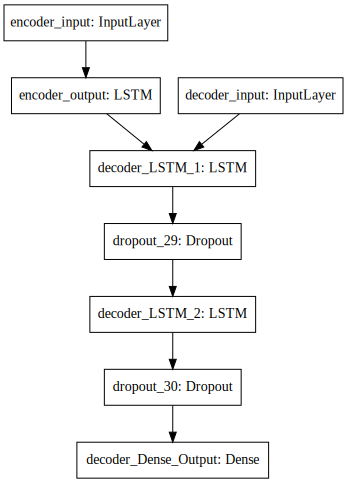

In [0]:
model, encoder_model, decoder_model = Character_Model(num_encoder_tokens, num_decoder_tokens, latent_dim)

rmsprop = optimizers.RMSprop(lr=0.002)

# Compile Model
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics = ['accuracy'])
# Print Model Summary
print(model.summary())
plot_model(model, to_file='Models/Character_Level_Model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))




Encoder Model


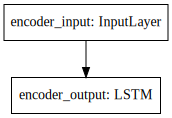

In [0]:
print()
print("Encoder Model")
plot_model(encoder_model, to_file='Models/Inference_Encoder_Character_Level_Model.png')
SVG(model_to_dot(encoder_model).create(prog='dot', format='svg'))


Decoder Model


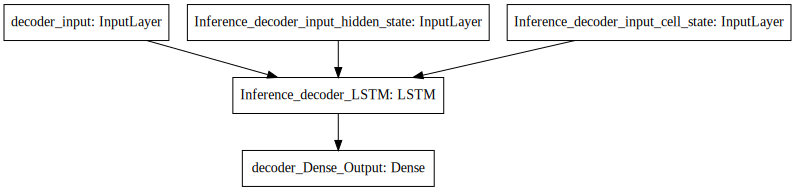

In [0]:
print()
print("Decoder Model")
plot_model(decoder_model, to_file='Models/Inference_Decoder_Character_Level_Model.png')
SVG(model_to_dot(decoder_model).create(prog='dot', format='svg'))

In [0]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=16,
                    epochs=10,
                    validation_split=0.01)

# Save model
model.save('s2s.h5')

Train on 49 samples, validate on 1 samples
Epoch 1/10
49/49 [==============================] - ETA: 13s - loss: 1.3563 - acc: 0.04 - ETA: 5s - loss: 1.3344 - acc: 0.0393 - ETA: 0s - loss: 1.3245 - acc: 0.035 - 17s 357ms/step - loss: 1.3096 - acc: 0.0346 - val_loss: 0.5845 - val_acc: 0.0161
Epoch 2/10
49/49 [==============================] - ETA: 6s - loss: 1.0620 - acc: 0.025 - ETA: 3s - loss: 1.1545 - acc: 0.035 - ETA: 0s - loss: 1.1839 - acc: 0.040 - 15s 303ms/step - loss: 1.1716 - acc: 0.0392 - val_loss: 0.5399 - val_acc: 0.0161
Epoch 3/10
49/49 [==============================] - ETA: 6s - loss: 1.2283 - acc: 0.037 - ETA: 3s - loss: 1.2739 - acc: 0.042 - ETA: 0s - loss: 1.1645 - acc: 0.042 - 15s 306ms/step - loss: 1.1715 - acc: 0.0428 - val_loss: 0.5360 - val_acc: 0.0161
Epoch 4/10
49/49 [==============================] - ETA: 6s - loss: 1.3453 - acc: 0.055 - ETA: 3s - loss: 1.1443 - acc: 0.043 - ETA: 0s - loss: 1.1511 - acc: 0.040 - 14s 287ms/step - loss: 1.1403 - acc: 0.0395 - val

c:\python36\lib\site-packages\keras\engine\network.py:888: UserWarning: Layer decoder_LSTM_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_output_32/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_output_32/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [0]:
while True:
    try:
        run_again = int(input("Do you want to run the Model again for 1 epoch more? (1 - Yes | 0 - No) : "))
        if run_again == 1:
            model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=16,
                    epochs=100,
                    validation_split=0.2)
        else:
            break
    except Exception as e:
        break

Do you want to run the Model again for 1 epoch more? (1 - Yes | 0 - No) : 1
Train on 40 samples, validate on 10 samples
Epoch 1/100
40/40 [==============================] - ETA: 4s - loss: 1.2780 - acc: 0.060 - ETA: 1s - loss: 1.1554 - acc: 0.052 - 22s 543ms/step - loss: 1.0949 - acc: 0.0500 - val_loss: 1.1057 - val_acc: 0.0565
Epoch 2/100
40/40 [==============================] - ETA: 4s - loss: 1.1453 - acc: 0.052 - ETA: 1s - loss: 1.1272 - acc: 0.052 - 21s 526ms/step - loss: 1.0781 - acc: 0.0484 - val_loss: 1.1000 - val_acc: 0.0597
Epoch 3/100
40/40 [==============================] - ETA: 4s - loss: 1.0062 - acc: 0.048 - ETA: 1s - loss: 1.0850 - acc: 0.050 - 21s 514ms/step - loss: 1.0817 - acc: 0.0516 - val_loss: 1.1030 - val_acc: 0.0597
Epoch 4/100
40/40 [==============================] - ETA: 4s - loss: 1.1486 - acc: 0.056 - ETA: 1s - loss: 1.1219 - acc: 0.052 - 21s 524ms/step - loss: 1.0769 - acc: 0.0512 - val_loss: 1.0993 - val_acc: 0.0613
Epoch 5/100
40/40 [=====================

40/40 [==============================] - ETA: 5s - loss: 0.9976 - acc: 0.101 - ETA: 1s - loss: 0.9589 - acc: 0.086 - 24s 597ms/step - loss: 0.9329 - acc: 0.0831 - val_loss: 1.0877 - val_acc: 0.0694
Epoch 40/100
40/40 [==============================] - ETA: 5s - loss: 0.8890 - acc: 0.080 - ETA: 1s - loss: 0.9412 - acc: 0.081 - 24s 593ms/step - loss: 0.9343 - acc: 0.0770 - val_loss: 1.0806 - val_acc: 0.0597
Epoch 41/100
40/40 [==============================] - ETA: 5s - loss: 0.8885 - acc: 0.069 - ETA: 1s - loss: 0.9356 - acc: 0.077 - 28s 706ms/step - loss: 0.9511 - acc: 0.0794 - val_loss: 1.0674 - val_acc: 0.0694
Epoch 42/100
40/40 [==============================] - ETA: 6s - loss: 0.9107 - acc: 0.083 - ETA: 2s - loss: 0.9024 - acc: 0.078 - 28s 708ms/step - loss: 0.9271 - acc: 0.0815 - val_loss: 1.0687 - val_acc: 0.0726
Epoch 43/100
40/40 [==============================] - ETA: 7s - loss: 0.8367 - acc: 0.079 - ETA: 2s - loss: 0.9290 - acc: 0.090 - 30s 754ms/step - loss: 0.9229 - acc: 0.

Epoch 78/100
40/40 [==============================] - ETA: 8s - loss: 0.6342 - acc: 0.100 - ETA: 2s - loss: 0.7486 - acc: 0.127 - 39s 964ms/step - loss: 0.7679 - acc: 0.1290 - val_loss: 1.2029 - val_acc: 0.0855
Epoch 79/100
40/40 [==============================] - ETA: 3s - loss: 0.9333 - acc: 0.132 - ETA: 1s - loss: 0.8372 - acc: 0.119 - 17s 417ms/step - loss: 0.7861 - acc: 0.1157 - val_loss: 1.1570 - val_acc: 0.0839
Epoch 80/100
40/40 [==============================] - ETA: 3s - loss: 0.6976 - acc: 0.109 - ETA: 1s - loss: 0.7609 - acc: 0.129 - 17s 418ms/step - loss: 0.7674 - acc: 0.1246 - val_loss: 1.2365 - val_acc: 0.0742
Epoch 81/100
40/40 [==============================] - ETA: 3s - loss: 0.9802 - acc: 0.155 - ETA: 1s - loss: 0.8128 - acc: 0.141 - 16s 392ms/step - loss: 0.7736 - acc: 0.1379 - val_loss: 1.1507 - val_acc: 0.0790
Epoch 82/100
40/40 [==============================] - ETA: 3s - loss: 0.9531 - acc: 0.133 - ETA: 1s - loss: 0.7869 - acc: 0.107 - 16s 408ms/step - loss: 0.7

In [0]:
while True:
    try:
        run_again = int(input("Do you want to run the Model again for 1 epoch more? (1 - Yes | 0 - No) : "))
        if run_again == 1:
            history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=16,
                    epochs=1000,
                    validation_split=0.2)
        else:
            break
    except Exception as e:
        break

Do you want to run the Model again for 1 epoch more? (1 - Yes | 0 - No) : 1
Train on 40 samples, validate on 10 samples
Epoch 1/1000
40/40 [==============================] - ETA: 3s - loss: 0.6921 - acc: 0.122 - ETA: 1s - loss: 0.6983 - acc: 0.151 - 20s 494ms/step - loss: 0.6957 - acc: 0.1452 - val_loss: 1.1281 - val_acc: 0.0790
Epoch 2/1000
40/40 [==============================] - ETA: 3s - loss: 0.7279 - acc: 0.129 - ETA: 1s - loss: 0.6723 - acc: 0.139 - 17s 420ms/step - loss: 0.6947 - acc: 0.1427 - val_loss: 1.2058 - val_acc: 0.0855
Epoch 3/1000
40/40 [==============================] - ETA: 3s - loss: 0.7233 - acc: 0.148 - ETA: 1s - loss: 0.6817 - acc: 0.146 - 16s 409ms/step - loss: 0.6864 - acc: 0.1496 - val_loss: 1.1574 - val_acc: 0.0887
Epoch 4/1000
40/40 [==============================] - ETA: 3s - loss: 0.5748 - acc: 0.128 - ETA: 1s - loss: 0.6294 - acc: 0.128 - 16s 394ms/step - loss: 0.7106 - acc: 0.1347 - val_loss: 1.1828 - val_acc: 0.0839
Epoch 5/1000
40/40 [================

40/40 [==============================] - ETA: 2s - loss: 0.6393 - acc: 0.226 - ETA: 0s - loss: 0.5662 - acc: 0.186 - 16s 389ms/step - loss: 0.5562 - acc: 0.1859 - val_loss: 1.2161 - val_acc: 0.1000
Epoch 40/1000
40/40 [==============================] - ETA: 3s - loss: 0.5451 - acc: 0.164 - ETA: 1s - loss: 0.5739 - acc: 0.179 - 16s 398ms/step - loss: 0.5654 - acc: 0.1823 - val_loss: 1.2972 - val_acc: 0.0984
Epoch 41/1000
40/40 [==============================] - ETA: 3s - loss: 0.5797 - acc: 0.206 - ETA: 1s - loss: 0.5846 - acc: 0.205 - 15s 386ms/step - loss: 0.5464 - acc: 0.1871 - val_loss: 1.2656 - val_acc: 0.1000
Epoch 42/1000
40/40 [==============================] - ETA: 2s - loss: 0.4163 - acc: 0.126 - ETA: 1s - loss: 0.5370 - acc: 0.174 - 16s 398ms/step - loss: 0.5418 - acc: 0.1859 - val_loss: 1.3117 - val_acc: 0.1000
Epoch 43/1000
40/40 [==============================] - ETA: 3s - loss: 0.5192 - acc: 0.157 - ETA: 1s - loss: 0.5322 - acc: 0.183 - 15s 385ms/step - loss: 0.5379 - acc

Epoch 78/1000
40/40 [==============================] - ETA: 3s - loss: 0.3761 - acc: 0.179 - ETA: 0s - loss: 0.4224 - acc: 0.208 - 15s 386ms/step - loss: 0.4361 - acc: 0.2226 - val_loss: 1.3255 - val_acc: 0.1000
Epoch 79/1000
40/40 [==============================] - ETA: 3s - loss: 0.3423 - acc: 0.180 - ETA: 1s - loss: 0.4039 - acc: 0.221 - 16s 389ms/step - loss: 0.4154 - acc: 0.2290 - val_loss: 1.3037 - val_acc: 0.1000
Epoch 80/1000
40/40 [==============================] - ETA: 3s - loss: 0.4296 - acc: 0.227 - ETA: 1s - loss: 0.4079 - acc: 0.240 - 15s 386ms/step - loss: 0.4011 - acc: 0.2347 - val_loss: 1.3582 - val_acc: 0.1000
Epoch 81/1000
40/40 [==============================] - ETA: 2s - loss: 0.3997 - acc: 0.207 - ETA: 0s - loss: 0.3967 - acc: 0.229 - 16s 392ms/step - loss: 0.4180 - acc: 0.2262 - val_loss: 1.3810 - val_acc: 0.1032
Epoch 82/1000
40/40 [==============================] - ETA: 3s - loss: 0.4688 - acc: 0.262 - ETA: 1s - loss: 0.4191 - acc: 0.238 - 16s 398ms/step - loss

40/40 [==============================] - ETA: 2s - loss: 0.3494 - acc: 0.279 - ETA: 0s - loss: 0.3305 - acc: 0.265 - 15s 378ms/step - loss: 0.3211 - acc: 0.2597 - val_loss: 1.3437 - val_acc: 0.1097
Epoch 117/1000
40/40 [==============================] - ETA: 3s - loss: 0.3404 - acc: 0.282 - ETA: 0s - loss: 0.3252 - acc: 0.274 - 16s 389ms/step - loss: 0.3134 - acc: 0.2597 - val_loss: 1.3924 - val_acc: 0.1048
Epoch 118/1000
40/40 [==============================] - ETA: 2s - loss: 0.2658 - acc: 0.263 - ETA: 0s - loss: 0.2876 - acc: 0.258 - 16s 390ms/step - loss: 0.3146 - acc: 0.2629 - val_loss: 1.3417 - val_acc: 0.0952
Epoch 119/1000
40/40 [==============================] - ETA: 2s - loss: 0.3319 - acc: 0.255 - ETA: 0s - loss: 0.3330 - acc: 0.249 - 15s 387ms/step - loss: 0.3439 - acc: 0.2488 - val_loss: 1.4393 - val_acc: 0.0887
Epoch 120/1000
40/40 [==============================] - ETA: 3s - loss: 0.3870 - acc: 0.285 - ETA: 1s - loss: 0.3443 - acc: 0.260 - 15s 381ms/step - loss: 0.3274 -

40/40 [==============================] - ETA: 2s - loss: 0.2625 - acc: 0.248 - ETA: 1s - loss: 0.2652 - acc: 0.264 - 16s 407ms/step - loss: 0.2613 - acc: 0.2774 - val_loss: 1.5514 - val_acc: 0.0919
Epoch 155/1000
40/40 [==============================] - ETA: 3s - loss: 0.2466 - acc: 0.268 - ETA: 1s - loss: 0.2582 - acc: 0.273 - 16s 404ms/step - loss: 0.2538 - acc: 0.2819 - val_loss: 1.5071 - val_acc: 0.0935
Epoch 156/1000
40/40 [==============================] - ETA: 3s - loss: 0.2435 - acc: 0.284 - ETA: 1s - loss: 0.2527 - acc: 0.287 - 18s 450ms/step - loss: 0.2538 - acc: 0.2823 - val_loss: 1.6060 - val_acc: 0.0919
Epoch 157/1000
40/40 [==============================] - ETA: 3s - loss: 0.3292 - acc: 0.348 - ETA: 1s - loss: 0.2909 - acc: 0.284 - 18s 444ms/step - loss: 0.2691 - acc: 0.2710 - val_loss: 1.6272 - val_acc: 0.0887
Epoch 158/1000
40/40 [==============================] - ETA: 3s - loss: 0.2600 - acc: 0.278 - ETA: 1s - loss: 0.2844 - acc: 0.286 - 17s 437ms/step - loss: 0.2712 -

40/40 [==============================] - ETA: 3s - loss: 0.1970 - acc: 0.279 - ETA: 1s - loss: 0.2101 - acc: 0.297 - 18s 438ms/step - loss: 0.2100 - acc: 0.2907 - val_loss: 1.5525 - val_acc: 0.1032
Epoch 193/1000
40/40 [==============================] - ETA: 3s - loss: 0.2387 - acc: 0.283 - ETA: 1s - loss: 0.2194 - acc: 0.298 - 18s 450ms/step - loss: 0.2206 - acc: 0.2899 - val_loss: 1.7148 - val_acc: 0.0871
Epoch 194/1000
40/40 [==============================] - ETA: 3s - loss: 0.2042 - acc: 0.290 - ETA: 1s - loss: 0.2154 - acc: 0.290 - 18s 454ms/step - loss: 0.2184 - acc: 0.2919 - val_loss: 1.6146 - val_acc: 0.0968
Epoch 195/1000
40/40 [==============================] - ETA: 3s - loss: 0.1960 - acc: 0.263 - ETA: 1s - loss: 0.1960 - acc: 0.270 - 18s 457ms/step - loss: 0.1959 - acc: 0.2992 - val_loss: 1.6598 - val_acc: 0.0968
Epoch 196/1000
40/40 [==============================] - ETA: 3s - loss: 0.1984 - acc: 0.217 - ETA: 1s - loss: 0.1994 - acc: 0.248 - 18s 440ms/step - loss: 0.2195 -

40/40 [==============================] - ETA: 3s - loss: 0.1679 - acc: 0.349 - ETA: 1s - loss: 0.1661 - acc: 0.301 - 15s 385ms/step - loss: 0.1737 - acc: 0.3000 - val_loss: 1.6306 - val_acc: 0.0871
Epoch 231/1000
40/40 [==============================] - ETA: 3s - loss: 0.1816 - acc: 0.283 - ETA: 1s - loss: 0.1946 - acc: 0.313 - 15s 378ms/step - loss: 0.1870 - acc: 0.3024 - val_loss: 1.6215 - val_acc: 0.0952
Epoch 232/1000
40/40 [==============================] - ETA: 3s - loss: 0.1685 - acc: 0.295 - ETA: 1s - loss: 0.1765 - acc: 0.298 - 15s 387ms/step - loss: 0.1818 - acc: 0.3008 - val_loss: 1.7276 - val_acc: 0.0790
Epoch 233/1000
40/40 [==============================] - ETA: 3s - loss: 0.1903 - acc: 0.313 - ETA: 0s - loss: 0.1849 - acc: 0.310 - 15s 378ms/step - loss: 0.1824 - acc: 0.3024 - val_loss: 1.6347 - val_acc: 0.0984
Epoch 234/1000
40/40 [==============================] - ETA: 3s - loss: 0.1790 - acc: 0.294 - ETA: 1s - loss: 0.1812 - acc: 0.302 - 15s 385ms/step - loss: 0.1829 -

40/40 [==============================] - ETA: 3s - loss: 0.1879 - acc: 0.318 - ETA: 0s - loss: 0.1616 - acc: 0.328 - 15s 385ms/step - loss: 0.1577 - acc: 0.3069 - val_loss: 1.8101 - val_acc: 0.0952
Epoch 269/1000
40/40 [==============================] - ETA: 2s - loss: 0.1503 - acc: 0.324 - ETA: 0s - loss: 0.1598 - acc: 0.322 - 16s 389ms/step - loss: 0.1600 - acc: 0.3097 - val_loss: 1.7352 - val_acc: 0.1000
Epoch 270/1000
40/40 [==============================] - ETA: 2s - loss: 0.1724 - acc: 0.324 - ETA: 0s - loss: 0.1604 - acc: 0.343 - 15s 384ms/step - loss: 0.1561 - acc: 0.3101 - val_loss: 1.7610 - val_acc: 0.0919
Epoch 271/1000
40/40 [==============================] - ETA: 2s - loss: 0.1549 - acc: 0.254 - ETA: 1s - loss: 0.1602 - acc: 0.290 - 16s 389ms/step - loss: 0.1655 - acc: 0.3065 - val_loss: 1.7303 - val_acc: 0.1000
Epoch 272/1000
40/40 [==============================] - ETA: 2s - loss: 0.1812 - acc: 0.360 - ETA: 0s - loss: 0.1698 - acc: 0.334 - 15s 384ms/step - loss: 0.1619 -

40/40 [==============================] - ETA: 2s - loss: 0.1350 - acc: 0.276 - ETA: 1s - loss: 0.1411 - acc: 0.292 - 16s 391ms/step - loss: 0.1448 - acc: 0.3121 - val_loss: 1.7859 - val_acc: 0.0935
Epoch 307/1000
40/40 [==============================] - ETA: 2s - loss: 0.1511 - acc: 0.346 - ETA: 0s - loss: 0.1440 - acc: 0.343 - 16s 393ms/step - loss: 0.1411 - acc: 0.3157 - val_loss: 1.8183 - val_acc: 0.0919
Epoch 308/1000
40/40 [==============================] - ETA: 3s - loss: 0.1433 - acc: 0.294 - ETA: 1s - loss: 0.1512 - acc: 0.347 - 15s 384ms/step - loss: 0.1442 - acc: 0.3121 - val_loss: 1.8648 - val_acc: 0.0935
Epoch 309/1000
40/40 [==============================] - ETA: 3s - loss: 0.1405 - acc: 0.321 - ETA: 1s - loss: 0.1376 - acc: 0.308 - 15s 386ms/step - loss: 0.1371 - acc: 0.3202 - val_loss: 1.8199 - val_acc: 0.0919
Epoch 310/1000
40/40 [==============================] - ETA: 2s - loss: 0.1319 - acc: 0.278 - ETA: 0s - loss: 0.1348 - acc: 0.297 - 16s 388ms/step - loss: 0.1370 -

40/40 [==============================] - ETA: 2s - loss: 0.1262 - acc: 0.261 - ETA: 0s - loss: 0.1299 - acc: 0.316 - 15s 384ms/step - loss: 0.1268 - acc: 0.3194 - val_loss: 1.7962 - val_acc: 0.1048
Epoch 345/1000
40/40 [==============================] - ETA: 3s - loss: 0.1266 - acc: 0.372 - ETA: 1s - loss: 0.1212 - acc: 0.336 - 16s 396ms/step - loss: 0.1202 - acc: 0.3238 - val_loss: 1.8860 - val_acc: 0.1016
Epoch 346/1000
40/40 [==============================] - ETA: 3s - loss: 0.1299 - acc: 0.261 - ETA: 1s - loss: 0.1242 - acc: 0.302 - 16s 398ms/step - loss: 0.1282 - acc: 0.3202 - val_loss: 1.8198 - val_acc: 0.0984
Epoch 347/1000
40/40 [==============================] - ETA: 3s - loss: 0.1326 - acc: 0.296 - ETA: 1s - loss: 0.1338 - acc: 0.317 - 16s 392ms/step - loss: 0.1308 - acc: 0.3190 - val_loss: 1.8557 - val_acc: 0.0919
Epoch 348/1000
40/40 [==============================] - ETA: 3s - loss: 0.1369 - acc: 0.355 - ETA: 1s - loss: 0.1307 - acc: 0.344 - 16s 393ms/step - loss: 0.1306 -

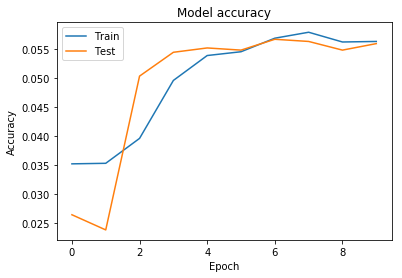

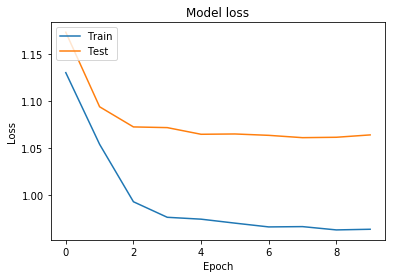

In [0]:


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
for seq_index in range(5):

    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador is finicky and she appreciates this product better than most.
Decoded sentence: ggggggggggyyyyyyyyyuyyyyyyuyyyyyuyyyyyuyyyyyuyyyyyuyyyyyuyyyyyuyyyyy
-
Input sentence: product arrived labeled as jumbo salted peanuts...the peanuts were actually small sized unsalted. not sure if this was an error or if the vendor intended to represent the product as  jumbo .
Decoded sentence: ggggggggggyyyyyyyyyuyyyyyyuyyyyyuyyyyyuyyyyyuyyyyyuyyyyyuyyyyyuyyyyy
-
Input sentence: this is a confection that has been around a few centuries. it is a light, pillowy citrus gelatin with nuts   in this case filberts. and it is cut into tiny squares and then liberally coated with powdered sugar. and it is a tiny mouthful of heaven. not too chewy, and very flavorful. i highly recommend this yummy treat

In [0]:
def generic_Model(n_input, n_output, n_units):
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,  initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    # return all models
    return model, encoder_model, decoder_model


In [0]:
training_model, encoder_model, decoder_model = generic_Model(max_encoder_seq_length, max_decoder_seq_length, 128)
training_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, 2297)   0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, None, 67)     0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 128), (None, 1242112     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_5 (LSTM)                   [(None, None, 128),  100352      input_8[0][0]                    
                                                                 lstm_4[0][1]                     
          

In [0]:
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
training_model.fit([input_characters, target_characters], target_characters,
batch_size=batch_size,
epochs=epochs,
validation_split=0.2)

ValueError: Error when checking input: expected input_7 to have 3 dimensions, but got array with shape (42, 1)

In [17]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

400000it [00:06, 58737.16it/s]


In [3]:
print(len(word_to_vec_map))
print(word_to_index["didn't"])
print(word_to_vec_map["strife-torn"])

400000


KeyError: ignored

In [18]:
word = "cucumber"
index = 289846
print(len(word_to_vec_map[word]))
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])
print(len(word_to_vec_map))

50
the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos
400000


**Exercise**: Implement `sentence_to_avg()`. This function performs two steps described as follows:
1. Convert every sentence to lower-case, then split the sentence into a list of words.
2. For each word in the sentence, access its GloVe representation. Then, average all these values.

In [0]:
# GRADED FUNCTION: sentence_to_avg

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    ### START CODE HERE ###
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = [i.lower() for i in sentence.split()]
    
    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((len(word_to_vec_map["a"]),))
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        try:
            avg += word_to_vec_map[w]
        except KeyError:
            print(w)
            continue
        
    avg = avg / len(words)
    
    ### END CODE HERE ###
    
    return avg

In [20]:
avg = sentence_to_avg("at least two people were killed in a suspected bomb attack on a passenger bus in the strife-torn southern philippines on monday , the military said .\n", word_to_vec_map)
print("avg = ", avg)

strife-torn
avg =  [ 6.00406333e-01 -3.32836241e-02  1.87963111e-01  6.77701481e-02
  3.54529296e-01  5.80289259e-02 -5.28430741e-01  2.34516926e-02
 -4.44399430e-02 -4.49052852e-01 -4.94001852e-02 -5.91713370e-01
 -3.30848889e-01 -3.86380000e-02  2.55290974e-01 -1.00995963e-01
 -2.50230633e-01  1.57850185e-01 -8.12166667e-01  1.53866296e-02
  1.62483900e-01  3.39234815e-01  1.11209556e-01  1.11625963e-02
 -1.28282022e-01 -1.71446667e+00 -3.79737037e-02  7.29834074e-02
  7.51024444e-02 -5.31830370e-02  3.21913704e+00 -1.57129481e-02
 -3.00656678e-01 -2.03952637e-01  3.13164624e-01  7.13015852e-02
  1.96886630e-01 -2.07194259e-01 -1.68992593e-03  3.62324111e-01
 -3.64241751e-01  2.49083281e-01  2.42211593e-01 -2.78113704e-01
  2.00010611e-01  2.41158148e-02 -4.04617674e-01 -2.34434815e-02
  1.46426704e-01 -3.46355148e-01]


In [0]:
def preprocess_data(X):
    from tqdm import tqdm
    
    m = len(X)
    str_check = [",", ".", '"', "'", "(", ")", "$", "mph", "-", "_"]
    str_remove = ["-lrb-", "-rrb-"]
    
    for i in tqdm(range(m)):
        sentence_words = [w for w in X[i].split()]
        j = 0
        new_string = ""
        if(i == 0):
            print(X[i])
        
        for w in sentence_words:
            try:
               _ = word_to_index[w]
            except KeyError:
                for stri_r in str_remove:
                    if(stri_r in w):
                        #print(stri_r)
                        w = w.replace(stri_r," ")
                for stri in str_check:
                    if(stri in w):
                        idx = w.index(stri)
                        if(w[idx:idx+2] == "'s"):
                            stri = "'s"
                            idx = w.index(stri)
                            a = w[:idx]
                            b = w[idx + 2:]
                            w = a + " " + stri + " " + b
                            continue
                        elif(w[idx:idx+3] == "mph"):
                            stri = "mph"
                            idx = w.index(stri)
                            if(w[idx - 1] == " "):
                                a = ""
                            else:
                                a = w[:idx]
                            b = w[idx + 3:]
                            w = a + " " + stri + " " + b
                            continue
                        if(w[idx - 1] == " "):
                            a = ""
                        else:
                            a = w[:idx]

                        b = w[idx + 1:]
                        w = a + " " + stri + " " + b
            
            new_string += w + " "
        X[i] = new_string
        if(i == 0):
            print(X[i])
    return X

In [0]:
# GRADED FUNCTION: sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    from tqdm import tqdm
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = len(X)                                # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in tqdm(range(m)):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [w.lower() for w in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                #if(w == "<unk>"):
                    #X_indices[i, j] = -1
                #else:
                    #X_indices[i, j] = word_to_index[w]
                X_indices[i, j] = word_to_index[w]
            except Exception as e:
                #print(e)
                pass
            # Increment j to j + 1
            j += 1
            
    ### END CODE HERE ###
    
    return X_indices

In [0]:
# GRADED FUNCTION: sentences_to_indices

def sentences_to_indices_reversed(X, word_to_index, max_len):
    from tqdm import tqdm
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = len(X)                                # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in tqdm(range(m)):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = [w.lower() for w in X[i].split()]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                #if(w == "<unk>"):
                    #X_indices[i, j] = -1
                #else:
                    #X_indices[i, j] = word_to_index[w]
                X_indices[i, - 1 - j] = word_to_index[w]
            except Exception as e:
                #print(e)
                pass
            # Increment j to j + 1
            j += 1
            
    ### END CODE HERE ###
    
    return X_indices

In [24]:
X = open("train.article.10000.txt").readlines()[:100]
X = preprocess_data(X)
print(len(X))
length = [len(x.split()) for x in X]
maxLen = max(length)
print(maxLen)
X1 = sentences_to_indices_reversed(X, word_to_index, maxLen)
print(X1.shape)

print("X[0] =", X[9])
print("X1_indices[0] =", X1[9])

print("X[0] =", X[length.index(max(length))])
print("X1_indices[0] =", X1[length.index(max(length))])


Y = open("train.title.10000.txt").readlines()[:100]
Y = preprocess_data(Y)
print(len(Y))
length_Y = [len(y.split()) for y in Y]
maxLen_Y = max(length_Y)
print(maxLen_Y)
Y1 = sentences_to_indices(Y, word_to_index, maxLen_Y)
print(Y1.shape)
print("Y[0] =", Y[0])
print("Y1_indices[0] =", Y1[0])
print("Y[0] =", Y[length_Y.index(max(length_Y))])
print("Y1_indices[0] =", Y1[length_Y.index(max(length_Y))])

100%|██████████| 100/100 [00:00<00:00, 31368.66it/s]

australia 's current account deficit shrunk by a record #.## billion dollars -lrb- #.## billion us -rrb- in the june quarter due to soaring commodity prices , figures released monday showed .

australia 's current account deficit shrunk by a record # . ## billion dollars   # . ## billion us   in the june quarter due to soaring commodity prices , figures released monday showed . 
100
41
(100, 41)
X[0] = the united nations ' humanitarian chief john holmes arrived in ethiopia monday to tour regions affected by drought , which has left some eight million people in need of urgent food aid . 
X1_indices[0] = [0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 8.67000e+02 4.88310e+04 1.51204e+05 3.73814e+05
 2.68046e+05 2.58451e+05 1.88481e+05 2.80944e+05 2.44641e+05 1.34390e+05
 3.37259e+05 2.19577e+05 1.74032e+05 3.86474e+05 4.52000e+02 1.29635e+05
 8.81260e+04 4.74860e+04 3.04268e+05 3.62970e+05 3.60915e+05 2.48403e+05
 1.40306e+05 1.88481e+05 

In [25]:
print(index_to_word[341956])

state


In [0]:
def convert_to_one_hot(X, word_to_index):
    
    m = X.shape[0]
    dim = X.shape[1]
    print(type(X))
    length = len(word_to_index) + 1
    print(length)
    
    Z = np.zeros((m, dim, length + 1))
    
    
    for i in tqdm(range(m)):
        for j in range(dim):
            if(j > 0):
                if(X[i,j] == -1):
                    Z[i, j, length] = 1
                else:
                    idx = X[i,j]
                    Z[i, j - 1, int(idx)] = 1
                
    return Z

In [27]:
decoder_target_data = convert_to_one_hot(Y1, word_to_index)
decoder_target_data[0]

<class 'numpy.ndarray'>
400001


100%|██████████| 100/100 [00:00<00:00, 28480.37it/s]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
X2 = open("dataset/DUC/duc2002/data/test/summaries/Text.txt").readlines()
preprocess_data(X2)
X3 = sentences_to_indices(X2, word_to_index, max_len = 1500)
print("X2[0] =", X2[1])
print("X3_indices[0] =", X3[1])

FileNotFoundError: ignored

In [0]:
print(index_to_word[8])
print(word_to_index["#"])

In [0]:
# GRADED FUNCTION: pretrained_embedding_layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = True)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [29]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [0]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    # if True, the attention vector is shared across the input_dimensions where the attention is applied.
    SINGLE_ATTENTION_VECTOR = False
    TIME_STEPS = inputs.shape[1]
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    #print(TIME_STEPS)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(41, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = mul([inputs, a_probs])
    return output_attention_mul

In [0]:
def Model_Text(encoder_input_shape, word_to_vec_map, word_to_index, decoder_input_shape):
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of GloVe word vectors (= 50)
    
    sentence_indices = Input(encoder_input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices) 
    
    attention_mul = attention_3d_block(embeddings)
    
    X, state_h, state_c = LSTM(emb_dim, return_state=True)(attention_mul)
    
    
    encoder_states = [state_h, state_c]
    
    
    #Set up the decoder, using `encoder_states` as initial state.

    decoder_inputs = Input(decoder_input_shape, dtype = 'int32')
    
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(decoder_inputs) 
    
    x = LSTM(emb_dim, return_sequences = True)(embeddings, initial_state=encoder_states)
    
    decoder_outputs = Dense(vocab_len + 1, activation='softmax')(x)

    
    model = Model(inputs=[sentence_indices, decoder_inputs], outputs= decoder_outputs)
    
    
    # Encoder Model for Inference
    encoder_model = Model(sentence_indices, encoder_states)

    
    # Decoder Model for Inference
    decoder_state_input_h = Input(shape=(emb_dim,), name = "Inference_decoder_input_hidden_state")
    decoder_state_input_c = Input(shape=(emb_dim,), name = "Inference_decoder_input_cell_state")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs_1, state_h, state_c = LSTM(emb_dim,
                                               return_sequences=True, 
                                               return_state=True,
                                               name = "Inference_decoder_LSTM")(embeddings, initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]
    
    decoder_outputs_1 = Dense(vocab_len + 1, 
                              activation='softmax',
                              kernel_initializer= glorot_uniform(seed = 0),
                              bias_initializer='zeros',
                              name = "decoder_Dense_Output")(decoder_outputs_1)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                          [decoder_outputs_1] + decoder_states)

    return model, encoder_model, decoder_model

In [0]:
concatenator = Concatenate(axis = 1)

In [0]:
def Model_Text3(encoder_input_shape, word_to_vec_map, word_to_index, decoder_input_shape):
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of GloVe word vectors (= 50)
    
    sentence_indices = Input(encoder_input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices) 
    
    X, _, _ = LSTM(emb_dim, return_state=True)(embeddings)
    
    
    
    #Set up the decoder, using `encoder_states` as initial state.
    print(decoder_input_shape)
    print(encoder_input_shape)
    decoder_inputs = Input(decoder_input_shape, dtype='int32')
    
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(decoder_inputs)
    
    x, _, _ = LSTM(emb_dim, return_state=True)(embeddings)
    
    
    decoder1 = concatenator([X, x])
    
    decoder_outputs = Dense(vocab_len + 1, activation='softmax')(decoder1)

    
    model = Model(inputs=[sentence_indices, decoder_inputs], outputs= decoder_outputs)
    
    return model

In [0]:
def Model_Text2(encoder_input_shape, word_to_vec_map, word_to_index, decoder_input_shape):
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of GloVe word vectors (= 50)
    
    sentence_indices = Input(encoder_input_shape, dtype='int32')
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(sentence_indices) 
    
    X, _, _ = LSTM(emb_dim, return_state=True)(embeddings)
    
    
    #x = LSTM(emb_dim)(X)
    
    decoder_outputs = Dense(vocab_len + 1, activation='softmax')(X)

    
    model = Model(inputs=sentence_indices, outputs= decoder_outputs)
    
    return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 41)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 41, 50)       20000050    input_3[0][0]                    
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 50, 41)       0           embedding_4[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 50, 41)       1722        permute_2[0][0]                  
__________________________________________________________________________________________________
attention_

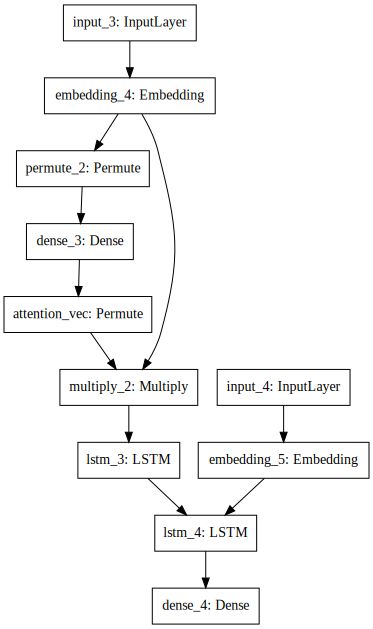

In [38]:
model, encoder_model, decoder_model = Model_Text((maxLen,), word_to_vec_map, word_to_index, (maxLen_Y,))
model.summary()
# Print Model Summary
plot_model(model, to_file='model_word_attention.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 41)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 41, 50)       20000050    input_3[0][0]                    
__________________________________________________________________________________________________
permute_2 (Permute)             (None, 50, 41)       0           embedding_4[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 50, 41)       1722        permute_2[0][0]                  
__________________________________________________________________________________________________
attention_

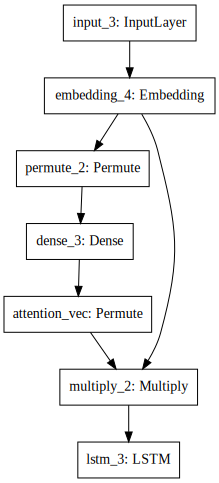

In [39]:
print(encoder_model.summary())
plot_model(model, to_file='encoder_model_word_attention.png')
SVG(model_to_dot(encoder_model).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 13, 50)       20000050    input_4[0][0]                    
__________________________________________________________________________________________________
Inference_decoder_input_hidden_ (None, 50)           0                                            
__________________________________________________________________________________________________
Inference_decoder_input_cell_st (None, 50)           0                                            
__________________________________________________________________________________________________
Inference_

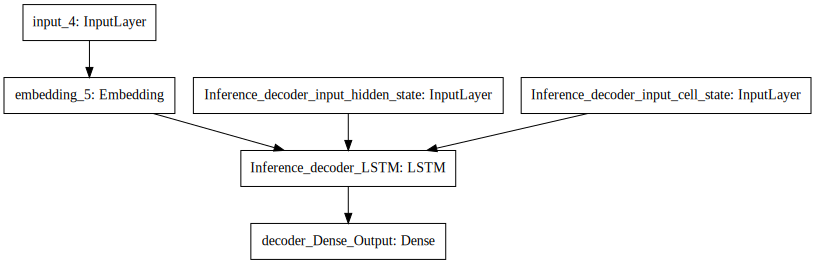

In [41]:
print(decoder_model.summary())
plot_model(model, to_file='decoder_model_word_attention.png')
SVG(model_to_dot(decoder_model).create(prog='dot', format='svg'))

In [0]:
rmsprop = optimizers.RMSprop(lr=0.02)
# Compile & run training
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics = ['accuracy'])

In [0]:
history = model.fit([X1, Y1], decoder_target_data, batch_size = 6, epochs = 10, shuffle = True) 

Epoch 1/10


In [0]:
history1 = model.fit([X1, Y1], decoder_target_data, batch_size = 6, epochs = 5, shuffle = True)

Epoch 1/5
100/100 [==============================] - ETA: 2:10 - loss: 3.4168 - acc: 0.487 - ETA: 2:02 - loss: 3.5411 - acc: 0.467 - ETA: 1:53 - loss: 3.5712 - acc: 0.474 - ETA: 1:44 - loss: 3.6777 - acc: 0.458 - ETA: 1:36 - loss: 3.7065 - acc: 0.456 - ETA: 1:28 - loss: 3.7533 - acc: 0.450 - ETA: 1:20 - loss: 3.8413 - acc: 0.441 - ETA: 1:12 - loss: 3.8035 - acc: 0.447 - ETA: 1:04 - loss: 3.7928 - acc: 0.448 - ETA: 55s - loss: 3.7556 - acc: 0.451 - ETA: 47s - loss: 3.6839 - acc: 0.46 - ETA: 39s - loss: 3.6377 - acc: 0.47 - ETA: 30s - loss: 3.6064 - acc: 0.48 - ETA: 22s - loss: 3.6689 - acc: 0.47 - ETA: 13s - loss: 3.7224 - acc: 0.46 - ETA: 5s - loss: 3.7434 - acc: 0.4639 - 140s 1s/step - loss: 3.7408 - acc: 0.4646
Epoch 2/5
100/100 [==============================] - ETA: 2:10 - loss: 3.4598 - acc: 0.474 - ETA: 2:01 - loss: 3.5369 - acc: 0.461 - ETA: 1:53 - loss: 3.5034 - acc: 0.474 - ETA: 1:45 - loss: 3.5641 - acc: 0.464 - ETA: 1:36 - loss: 3.5255 - acc: 0.476 - ETA: 1:28 - loss: 3.4711

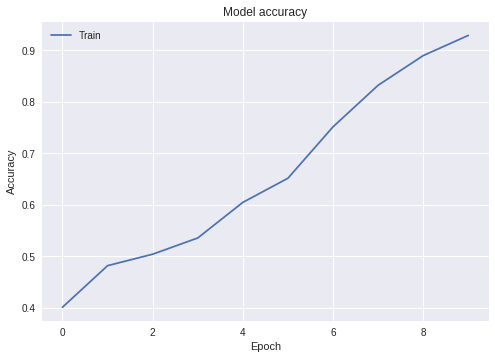

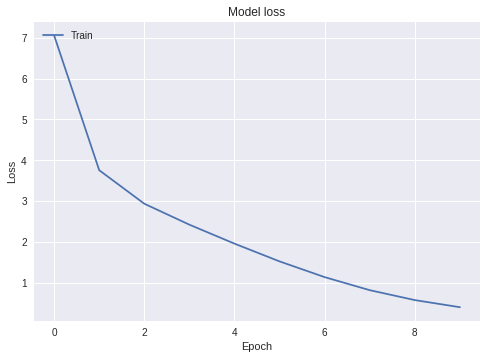

In [31]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Model_Acc_Word_level_1-1_input_reversed')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Model_Loss_Word_level_1-1_input_reversed')
plt.show()

In [0]:
def decode_word_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros(( 1, 13))
    # Populate the first character of target sequence with the start character.
    #target_seq[0, 0] = word_to_index['\t']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    i = 0
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        sampled_word = index_to_word[sampled_token_index]
        decoded_sentence += sampled_word + " "

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '\n' or
           len(decoded_sentence) > 41):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 13))
        target_seq[0, i] = sampled_token_index
        i += 1

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [33]:
for seq_index in range(10):

    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = X1[seq_index: seq_index + 1]
    print(input_seq.shape)
    decoded_sentence = decode_word_sequence(input_seq)

    print('-')
    print('Input sentence:', X[seq_index])
    print('Decoded sentence:', decoded_sentence)

(1, 41)
-
Input sentence: australia 's current account deficit shrunk by a record # . ## billion dollars   # . ## billion us   in the june quarter due to soaring commodity prices , figures released monday showed . 
Decoded sentence: chaptal 248.1 incredible incredible incredible 
(1, 41)
-
Input sentence: at least two people were killed in a suspected bomb attack on a passenger bus in the strife - torn southern philippines on monday , the military said . 
Decoded sentence: 61.08 mdrv incredible incredible incredible 
(1, 41)
-
Input sentence: australian shares closed down # . # percent monday following a weak lead from the united states and lower commodity prices , dealers said . 
Decoded sentence: nexis x51mm incredible incredible incredible 
(1, 41)
-
Input sentence: south korea 's nuclear envoy kim sook urged north korea monday to restart work to disable its nuclear plants and stop its `` typical '' brinkmanship in negotiations . 
Decoded sentence: wisemen warangal incredible incred

In [0]:
decoder_target_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
loss, acc = model.evaluate([X1 , Y1], decoder_target_data[:,:,:])
print("Accuracy" + str(acc))

100/100 [==============================] - ETA: 2: - ETA: 50s - ETA: 4 - 117s 1s/step
Accuracy0.46461538195610047


In [0]:
acc

0.46461538195610047

In [0]:
idx = model.predict([X1[:10,:], Y1[:10,:]], verbose = 0)
print(idx.shape)
print(idx)
id1 = {}
for i in range(idx.shape[0]):
    id1[str(i)] = []
    for j in range(idx.shape[1]):
        try:
            id1[str(i)].append(index_to_word[np.argmax(idx[i,j,:])])
        except Exception as e:
            id1[str(i)].append(index_to_word[np.argmax(idx[i,j,:]) + 1])
            pass
print(id1)

(10, 13, 400002)
[[[3.9995812e-02 1.9187546e-06 1.9409463e-06 ... 1.9284203e-06
   1.9194865e-06 1.9712222e-06]
  [3.9996184e-02 1.9187485e-06 1.9409422e-06 ... 1.9284159e-06
   1.9194804e-06 1.9712161e-06]
  [3.9996240e-02 1.9187494e-06 1.9409392e-06 ... 1.9284153e-06
   1.9194797e-06 1.9712152e-06]
  ...
  [3.9996248e-02 1.9187478e-06 1.9409397e-06 ... 1.9284155e-06
   1.9194799e-06 1.9712154e-06]
  [3.9996248e-02 1.9187496e-06 1.9409397e-06 ... 1.9284155e-06
   1.9194799e-06 1.9712154e-06]
  [3.9996248e-02 1.9187496e-06 1.9409397e-06 ... 1.9284155e-06
   1.9194817e-06 1.9712154e-06]]

 [[3.9995898e-02 1.9187530e-06 1.9409429e-06 ... 1.9284189e-06
   1.9194813e-06 1.9712188e-06]
  [3.9996196e-02 1.9187489e-06 1.9409408e-06 ... 1.9284166e-06
   1.9194811e-06 1.9712165e-06]
  [3.9996248e-02 1.9187478e-06 1.9409397e-06 ... 1.9284155e-06
   1.9194799e-06 1.9712154e-06]
  ...
  [3.9996266e-02 1.9187489e-06 1.9409406e-06 ... 1.9284166e-06
   1.9194811e-06 1.9712165e-06]
  [3.9996266e-02 1.

In [0]:
for seq_index in range(5):

    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

In [0]:
idx = model.predict([X1, Y1], verbose = 0)

In [0]:
print(idx.shape)
id = []
for i in range(idx.shape[0]):
    id.append(index_to_word[np.argmax(idx[i,:])])


In [0]:
id